Notebook 4: Evaluation and Strategy Backtesting

Objective: To evaluate the performance of our trained Mixture of Experts model and to backtest a simple trading strategy that adapts based on the predicted market regime.

Key Steps:

* Load all necessary data and the three trained expert models.

* Evaluate each expert's performance specifically on the data points corresponding to its designated regime.

* Define a simple, regime-aware trading strategy.

* Implement a backtesting engine to simulate the strategy on the test set.

* Calculate key performance metrics (e.g., Sharpe Ratio, Annualized Return).

* Visualize the strategy's performance (equity curve) against a simple buy-and-hold benchmark.

Cell 1: Import Libraries and Redefine the Expert Class

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
# Set a random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# We must redefine the Expert class exactly as it was during training
# so we can load the saved weights into it.
class Expert(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

Cell 2: Load Data, Models, and Prepare Scaler

In [30]:
# --- Load the dataset ---
# Use index_col=0 because the 'Date' column is the first one without a header
data_df = pd.read_csv('features_with_regimes.csv', index_col=0, parse_dates=True)

# --- Prepare data for scaling and splitting ---
feature_cols = ['Returns', 'Volatility', 'Momentum', 'Intraday_Range']
X = data_df[feature_cols].iloc[:-1] # Drop last row to align with target
y = data_df['Returns'].shift(-1).iloc[:-1]

# --- Re-split data to get the test set and fit the scaler ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
scaler = StandardScaler()
scaler.fit(X_train) # Fit scaler ONLY on training data
X_test_scaled = scaler.transform(X_test)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# --- Load the trained expert models ---
K = 3
input_dim = X_test_scaled.shape[1]
experts = [Expert(input_dim) for _ in range(K)]

for k in range(K):
    experts[k].load_state_dict(torch.load(f'expert_model_regime_{k}.pth'))
    experts[k].eval() # Set models to evaluation mode

print("Data, scaler, and all three trained expert models loaded successfully.")

Data, scaler, and all three trained expert models loaded successfully.


Cell 3: Per-Regime Performance Analysis

Let's see how well each expert performs on the days the HMM identified as its "specialty." This confirms that our experts have successfully specialized.

In [31]:
# Get the hard regime assignments for the test set
test_regimes = data_df['Regime'].loc[y_test.index]

with torch.no_grad():
    print("--- Per-Expert Performance on Test Set ---")
    for k in range(K):
        # Find the data points belonging to this regime
        regime_indices = (test_regimes == k)

        if regime_indices.sum() > 0:
            X_regime = X_test_tensor[regime_indices]
            y_regime = torch.tensor(y_test.values[regime_indices], dtype=torch.float32)

            # Get prediction from this expert
            pred_regime = experts[k](X_regime)

            mse = nn.MSELoss()(pred_regime, y_regime)
            print(f"Expert {k} (Regime {k}) MSE: {mse.item():.8f} on {regime_indices.sum()} samples.")
        else:
            print(f"No samples for Regime {k} in the test set.")

--- Per-Expert Performance on Test Set ---
Expert 0 (Regime 0) MSE: 0.00004757 on 574 samples.
Expert 1 (Regime 1) MSE: 0.00012589 on 570 samples.
Expert 2 (Regime 2) MSE: 0.00036697 on 144 samples.


Cell 4: Backtesting a Regime-Aware Strategy

Now for the main event. We will simulate a simple trading strategy that adapts based on the predicted regime for the next day. Our HMM gives us gammas which are probabilities. We will use the regime with the highest probability (argmax) as our signal.

Strategy Rules:

* If Regime 0 (Calm/Bullish) is predicted: Go long (buy and hold for the day).

* If Regime 1 (Crash/Bearish) is predicted: Go short (sell and hold for the day).

* If Regime 2 (Choppy/Sideways) is predicted: Stay in cash (neutral position).

In [32]:
# Get the predicted regimes for the test set
test_gammas = data_df[['gamma_0', 'gamma_1', 'gamma_2']].loc[y_test.index]
predicted_regimes = test_gammas.idxmax(axis=1).str.replace('gamma_', '').astype(int)

# --- Backtest Simulation ---
initial_capital = 100000.0
capital = initial_capital
positions = 0.0
portfolio_value = []

for i in range(len(y_test)):
    # The return for today is applied to the position we held from yesterday
    capital += positions * y_test.iloc[i]
    portfolio_value.append(capital)

    # Decide today's position for tomorrow's return based on today's signal
    regime_signal = predicted_regimes.iloc[i]

    if regime_signal == 0: # Bullish regime -> Go Long
        positions = capital
    elif regime_signal == 1: # Bearish regime -> Go Short
        positions = -capital
    else: # Neutral regime -> Stay in cash
        positions = 0

# --- Benchmark: Simple Buy and Hold ---
benchmark_returns = y_test.cumsum()
benchmark_value = initial_capital * (1 + benchmark_returns)

# Create a DataFrame for plotting
results_df = pd.DataFrame({
    'Strategy': portfolio_value,
    'Buy_and_Hold': benchmark_value.values
}, index=y_test.index)

print("Backtest complete.")

Backtest complete.


Cell 5: Calculate and Display Performance Metrics

In [33]:
# --- Performance Metrics Calculation ---
strategy_returns = results_df['Strategy'].pct_change().dropna()
benchmark_returns = results_df['Buy_and_Hold'].pct_change().dropna()

# Annualized Return
annualized_return_strategy = strategy_returns.mean() * 252
annualized_return_benchmark = benchmark_returns.mean() * 252

# Annualized Volatility (Risk)
annualized_vol_strategy = strategy_returns.std() * np.sqrt(252)
annualized_vol_benchmark = benchmark_returns.std() * np.sqrt(252)

# Sharpe Ratio (Risk-Adjusted Return)
sharpe_ratio_strategy = annualized_return_strategy / annualized_vol_strategy if annualized_vol_strategy != 0 else 0
sharpe_ratio_benchmark = annualized_return_benchmark / annualized_vol_benchmark if annualized_vol_benchmark != 0 else 0

print("--- Backtest Performance Metrics ---")
print(f"                 | Strategy      | Buy and Hold")
print(f"-----------------|---------------|---------------")
print(f"Annualized Return| {annualized_return_strategy:13.2%} | {annualized_return_benchmark:13.2%}")
print(f"Annualized Vol   | {annualized_vol_strategy:13.2%} | {annualized_vol_benchmark:13.2%}")
print(f"Sharpe Ratio     | {sharpe_ratio_strategy:13.2f} | {sharpe_ratio_benchmark:13.2f}")

--- Backtest Performance Metrics ---
                 | Strategy      | Buy and Hold
-----------------|---------------|---------------
Annualized Return|         1.07% |        11.54%
Annualized Vol   |        14.30% |        13.48%
Sharpe Ratio     |          0.08 |          0.86


Cell 6: Visualize the Backtest Results

The final equity curve plot will show the growth of our initial capital over time for both our regime-aware strategy and the simple buy-and-hold benchmark.

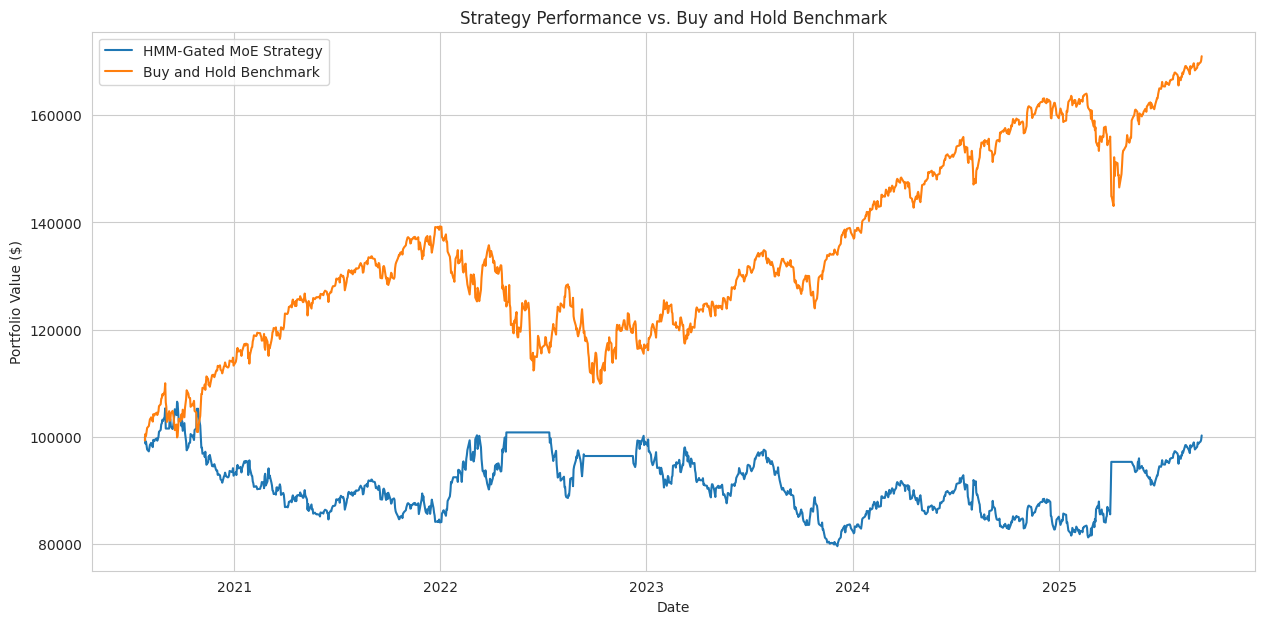

In [34]:
plt.figure(figsize=(15, 7))
plt.plot(results_df.index, results_df['Strategy'], label='HMM-Gated MoE Strategy')
plt.plot(results_df.index, results_df['Buy_and_Hold'], label='Buy and Hold Benchmark')
plt.title('Strategy Performance vs. Buy and Hold Benchmark')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()

Final Conclusion: This notebook demonstrates the practical application of our complex model. By analyzing the performance metrics and the equity curve, we can draw a conclusion about the effectiveness of using a regime-aware approach compared to a passive investment strategy. A higher Sharpe Ratio and a smoother, more consistent equity curve would indicate a successful project.